In this notebook we will demonstrate how to interpret a Deep Learning Model using [LIME](https://github.com/marcotcr/lime)(local interpretable model-agnostic explanations), a python package for explaining machine learning classifiers. 

In [25]:
# To install only the requirements of this notebook, uncomment the lines below and run this cell

# ===========================

# !pip install pandas==1.1.5
# !pip install scikit-learn==0.21.3
# !pip install lime==0.2.0.1
# !pip install tensorflow==1.14.0
# !pip install numpy==1.19.5
# !pip install matplotlib==3.2.2
# !pip install seaborn==0.11.1

# ===========================

In [26]:
# To install the requirements for the entire chapter, uncomment the lines below and run this cell

# ===========================

# try:
#     import google.colab
#     !curl  https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/ch4-requirements.txt | xargs -n 1 -L 1 pip install
# except ModuleNotFoundError:
#     !pip install -r "ch4-requirements.txt"

# ===========================

We will be building an LSTM model with an embedding layer trained on the fly. We will be following all the preprocessing steps as in the [DeepNN_Example.ipynb](https://github.com/practical-nlp/practical-nlp/blob/master/Ch4/DeepNN_Example.ipynb) notebook in this repo.

In [27]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow import keras
import os
import re
import pandas as pd

#helper functions to lead the data
def load_directory_data(directory):
    data = {}
    data["sentence"] = []
    data["sentiment"] = []
    for file_path in os.listdir(directory):
        with tf.io.gfile.GFile(os.path.join(directory, file_path), "r") as f:
            data["sentence"].append(f.read())
            data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
    return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
    pos_df = load_directory_data(os.path.join(directory, "pos"))
    neg_df = load_directory_data(os.path.join(directory, "neg"))
    pos_df["polarity"] = 1
    neg_df["polarity"] = 0
    return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

def download_and_load_datasets(force_download=False):
    dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)

    train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
    test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))
  
    return train_df, test_df

In [28]:
# try:
#     from google.colab import files
    
#     if not os.path.exists('aclImdb'):
#         train,test = download_and_load_datasets()
#     else:
#         train = load_dataset('aclImdb/train')
#         test = load_dataset('aclImdb/test')
    
# except ModuleNotFoundError:
#     # if not os.path.exists('data/bigdata/aclImdb'):
#     #     train,test = download_and_load_datasets()
#     if False:
#         train,test = download_and_load_datasets()
#     else:
#         train = load_dataset('data/bigdata/aclImdb/train')
#         test = load_dataset('Ddata/bigdata/aclImdb/test')
train = load_dataset('data/bigdata/aclImdb/train')
test = load_dataset('data/bigdata/aclImdb/test')

In [29]:
import os
import sys
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant
from sklearn.metrics import accuracy_score


MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000 
EMBEDDING_DIM = 100 
VALIDATION_SPLIT = 0.2

vocab_size = 20000  # Max number of different word, i.e. model input dimension
maxlen = 1000 # Max number of words kept at the end of each text

In [30]:
train.columns

Index(['sentence', 'sentiment', 'polarity'], dtype='object')

In [31]:
train_texts = train['sentence'].values
train_labels = train['polarity'].values
test_texts = test['sentence'].values
# test_labels = test['polarity'].values

labels_index = {'pos':1, 'neg':0} 

In [32]:
test.columns

Index(['sentence', 'sentiment', 'polarity'], dtype='object')

In [33]:
test_labels = test['polarity'].values
test_labels

array([1, 0, 0, ..., 0, 1, 1], dtype=int64)

We need to design an sklearn pipeline with our model.
What is a pipeline?<br>

**Transformer** in scikit-learn - some class that have fit and transform method, or fit_transform method.

**Predictor** - some class that has fit and predict methods, or fit_predict method.

**Pipeline** is just an abstract notion, it's not some existing ml algorithm. Often in ML tasks you need to perform sequence of different transformations (find set of features, generate new features, select only some good features) of raw dataset before applying final estimator. Pipeline gives you a single interface for all 3 steps of transformation and resulting estimator. It encapsulates transformers and predictors inside

In [34]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.pipeline import TransformerMixin
from sklearn.base import BaseEstimator


class TextsToSequences(Tokenizer, BaseEstimator, TransformerMixin):
    """ Sklearn transformer to convert texts to indices list 
    (e.g. [["the cute cat"], ["the dog"]] -> [[1, 2, 3], [1, 4]])"""
    def __init__(self,  **kwargs):
        super().__init__(**kwargs)
        
    def fit(self, texts, y=None):
        self.fit_on_texts(texts)
        return self
    
    def transform(self, texts, y=None):
        return np.array(self.texts_to_sequences(texts))
        
sequencer = TextsToSequences(num_words=vocab_size)




class Padder(BaseEstimator, TransformerMixin):
    """ Pad and crop uneven lists to the same length. 
    Only the end of lists longernthan the maxlen attribute are
    kept, and lists shorter than maxlen are left-padded with zeros
    
    Attributes
    ----------
    maxlen: int
        sizes of sequences after padding
    max_index: int
        maximum index known by the Padder, if a higher index is met during 
        transform it is transformed to a 0
    """
    def __init__(self, maxlen=500):
        self.maxlen = maxlen
        self.max_index = None
        
    def fit(self, X, y=None):
        self.max_index = pad_sequences(X, maxlen=self.maxlen).max()
        return self
    
    def transform(self, X, y=None):
        X = pad_sequences(X, maxlen=self.maxlen)
        X[X > self.max_index] = 0
        return X

padder = Padder(maxlen)

We will only train for 2 epochs. A better model could be trained with more epochs and early stopping.

In [38]:
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import make_pipeline

batch_size = 64
max_features = vocab_size + 1

#Training an LSTM with embedding on the fly
def create_model(max_features):
    """ Model creation function: returns a compiled LSTM"""


    rnnmodel = Sequential()
    rnnmodel.add(Embedding(MAX_NUM_WORDS, 128))
    rnnmodel.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    rnnmodel.add(Dense(1, activation='sigmoid'))
    rnnmodel.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return rnnmodel


# Use Keras Scikit-learn wrapper to instantiate a LSTM with all methods
# required by Scikit-learn for the last step of a Pipeline
sklearn_lstm = create_model(0)
# sklearn_lstm = KerasClassifier(build_fn=create_model, epochs=2, batch_size=32, 
#                                max_features=max_features, verbose=1)

# Build the Scikit-learn pipeline
pipeline = make_pipeline(sequencer, padder, sklearn_lstm)

pipeline.fit(train_texts, train_labels)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (25000,) + inhomogeneous part.

In [12]:
y_preds = pipeline.predict(test_texts)

25000/25000 [==============================] - 201s 8ms/sample


In [13]:
print('Test accuracy: {:.2f} %'.format(100*accuracy_score(y_preds, test_labels)))

Test accuracy: 79.89 %


Sample 11: last 1000 words (only part used by the model)
--------------------------------------------------
I had the privilege of being one of the Still photographers on the set of "Grand Champion" and enjoyed every minute of the 42 days I worked on the movie. I have been in the Photography business for 25 years and have worked on 16 movies and I can't think of a time when I enjoyed providing my craft more. The Kids were wonderful to work with and little Emma Roberts has so much energy she's a real trip. She even grabbed one of my camera during the stockshow scene rehearsal and started shooting. Some of her images were used for PR. I could have made more money working for a production with a bigger budget but I doubt I would have had the fun and been around so many great actors and the great people of West Texas as I was.
--------------------------------------------------
1/1 [==============================] - 0s 125ms/sample
Probability(positive) = 0.43980047
True class: positive
500

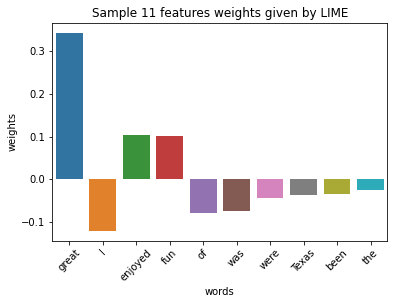

In [14]:
# We choose a sample from test set
idx = 11
text_sample = test_texts[idx]
class_names = ['negative', 'positive']

print('Sample {}: last 1000 words (only part used by the model)'.format(idx))
print('-'*50)
print(" ".join(text_sample.split()[-1000:]))
print('-'*50)
print('Probability(positive) =', pipeline.predict_proba([text_sample])[0,1])
print('True class: %s' % class_names[test_labels[idx]])



import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from collections import OrderedDict
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=class_names)
explanation = explainer.explain_instance(text_sample, pipeline.predict_proba, num_features=10)

weights = OrderedDict(explanation.as_list())
lime_weights = pd.DataFrame({'words': list(weights.keys()), 'weights': list(weights.values())})

sns.barplot(x="words", y="weights", data=lime_weights);
plt.xticks(rotation=45)
plt.title('Sample {} features weights given by LIME'.format(idx));

We have used the LIME interpretation to provide explanations for a recurrent neural network. Looking at the graph we understand that the sentence is negative and the word "worst" affects it the most.

